In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

from sklearn.datasets import load_iris
# from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

voting_file = './voting.pickle'

## Naive Bayes Classifier

Let us first implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

For now we'll only implement binary and real-valued features. They will suffice for the purposes of this practical.

In [2]:
class NBC:
    def __init__(self, feature_types=[], num_classes=0, alpha=0.0001):
        # Each element of the list must be one of binary, multivariate, real
        # C is the number of classes
        self.D = len(feature_types)
        self.Dtypes = feature_types
        self.C = num_classes
        # Parameter to be used for Laplace smoothing
        self.alpha = alpha
        # Initialise parameters
        self.init_parameters()
        # Flat to determine if any model has been fit
        self.fit_called = False
    
    def init_parameters(self):
        self.binary_vars = []
        self.real_vars = []
        self.multivariate_vars = []
        self.ignore_vars = []
        for (i, s) in enumerate(self.Dtypes):
            if s == 'b':
                self.binary_vars.append(i)
            elif s == 'm':
                ## MULTIVARIATE not yet implemented
                print('Warning: multivariate not yet implemented')
                self.multivariate_vars.append(i)
            elif s == 'r':
                self.real_vars.append(i)
            else:
                self.ignore_vars.append(i)
                print('Warning: Type %s not supported' % s)
        
        self.Theta_binary = np.zeros([self.C, len(self.binary_vars)])
        self.Theta_multivariate = [[{} for f in self.multivariate_vars] for c in range(self.C)]
        self.Theta_real = np.zeros([self.C, len(self.real_vars), 2])
        self.Theta_classes = np.zeros(self.C)
        
    def fit(self, X, y):
        N, D = X.shape
        # Map classes to integers in range {0, 1, ..., C-1}
        self.class_dict = {}
        for (i, c) in enumerate(set(y)):
            self.class_dict[int(c)] = i
        
        # Fit the parameters
        for c in self.class_dict.keys():
            examples = y == self.class_dict[c]
            self.Theta_classes[c] = np.mean(examples)
            for (i, f) in enumerate(self.binary_vars):
                self.Theta_binary[c][i] = (np.sum(X[examples, f]) + self.alpha) / (N + 2 * self.alpha)
            for (i, f) in enumerate(self.real_vars):
                self.Theta_real[c][i][0] = np.mean(X[examples, f])
                self.Theta_real[c][i][1] = max(np.var(X[examples, f]), 1e-10)  # Never want 0 variance
                
                
    def predict(self, X):
        N, D = X.shape
        if D != self.D:
            print('Expected X to have %d features, found %d.' % (self.D, D))
            print('Bad things may happen so giving up')
            return None
        log_prob = np.zeros([N, self.C])
        for c in self.class_dict.keys():
            log_prob[:, c] = np.log(self.Theta_classes[c])
            for (i, f) in enumerate(self.binary_vars):
                log_prob[:, c] += np.log(self.Theta_binary[c][i]) * X[:, f] 
                log_prob[:, c] += np.log(1 - self.Theta_binary[c][i]) * (1 - X[:, f])
            for (i, f) in enumerate(self.real_vars):
                log_prob[:, c] -= (X[:, f] - self.Theta_real[c][i][0])**2/ (2 * self.Theta_real[c][i][1])
                log_prob[:, c] -= 0.5 * np.log(2 * np.pi * self.Theta_real[c][i][1])
        
        ypreds = log_prob.argmax(axis=1)
        return [self.class_dict[t] for t in ypreds]

In [3]:
iris = load_iris()

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(iris['data'], iris['target'])

## Logistic Regression 

### Handin 1: 

The negative log-likelihood (from the lectures) + a regularisation term, would give the objective function:

$$\mathcal{L}_1(\mathbf{w}; \mathbf{X}, \mathbf{y}) = \sum_{i = 1}^N \log( 1 + \exp(-z_i(\mathbf{w} \cdot \mathbf{x}_i))) + \lambda \Vert \mathbf{w} \Vert^2 $$

Above $z_i = 2 y_i - 1$. The [documentation page](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) assumes that the objective function is (they also assume $y_i \in {-1, 1}$): 

$$\mathcal{L}_2(\mathbf{w}; \mathbf{X}, \mathbf{y}) = \frac{1}{2} \Vert \mathbf{w} \Vert^2 + C \sum_{i = 1}^N \log( 1 + \exp(-z_i(\mathbf{w} \cdot \mathbf{x}_i)))$$

For the two objectives to result in the same minimiser, we need to set $C = \frac{1}{2 \lambda}$. So if we want to use $\lambda = 0.1$, we need to set $C = 5$.

## Comparing NBC and LR

We will compare the performance of NBC and Logistic Regression trained on increasingly larger training sets. Since the datasets are small we'll average over many possible train/test splits. First split 20% of the data as test data. Then train on increasingly large fraction of training data and compute the test error. Repeat several times and store average test error. 


In [4]:
def compareNBCvsLR(nbc, lr, X, y, num_runs=400, num_splits=10):
    k = num_runs
    l = num_splits
    N, D = X.shape
    C = len(set(y))
    Ntrain = int(0.8 * N)
    tst_errs_nbc = np.zeros([k, l])
    tst_errs_lr = np.zeros([k, l])

    for i in range(k):
        shuffle = np.random.permutation(N)
     
        while len(set(y[shuffle[:(Ntrain // l)]])) < C:
            shuffle = np.random.permutation(N)
             
        for j in range(1, l + 1):
            nbc.fit(X[shuffle[:(Ntrain * j) // l]], y[shuffle[:(Ntrain * j) // l]])
            lr.fit(X[shuffle[:(Ntrain * j) // l]], y[shuffle[:(Ntrain * j) // l]])

            yhat_nbc = nbc.predict(X[shuffle[Ntrain:]])
            yhat_lr = lr.predict(X[shuffle[Ntrain:]])
            tst_errs_nbc[i, j-1] = 1 - np.mean(yhat_nbc == y[shuffle[Ntrain:]])
            tst_errs_lr[i, j-1] = 1 - np.mean(yhat_lr == y[shuffle[Ntrain:]])
    
    return tst_errs_nbc.mean(axis=0), tst_errs_lr.mean(axis=0)

We'll also define a utility function for plotting.

In [5]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression')
    
    ax.legend(loc='upper right', fontsize=20)

## Datasets

Finally, we'll compare the two classifiers NBC and LR on the iris and voting datasets.

In [6]:
# IRIS
iris = load_iris()

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
lr_iris = LogisticRegression()
nbc_perf_iris, lr_perf_iris = compareNBCvsLR(nbc_iris, lr_iris, iris['data'], iris['target'], num_runs=1000)

In [7]:
# Voting

X_voting, y_voting = cp.load(open(voting_file, 'rb'))
nbc_voting = NBC(feature_types=['b'] * 16, num_classes=2)
lr_voting = LogisticRegression()

nbc_perf_voting, lr_perf_voting = compareNBCvsLR(nbc_voting, lr_voting, X_voting, y_voting, num_runs = 1000)

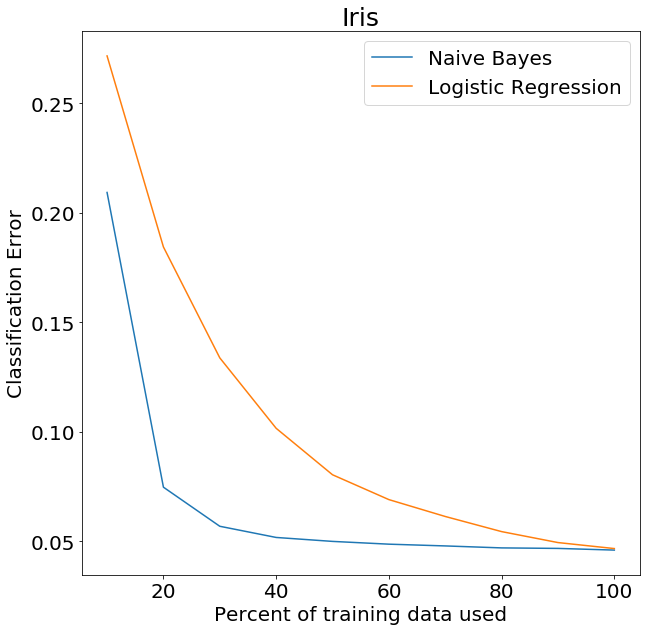

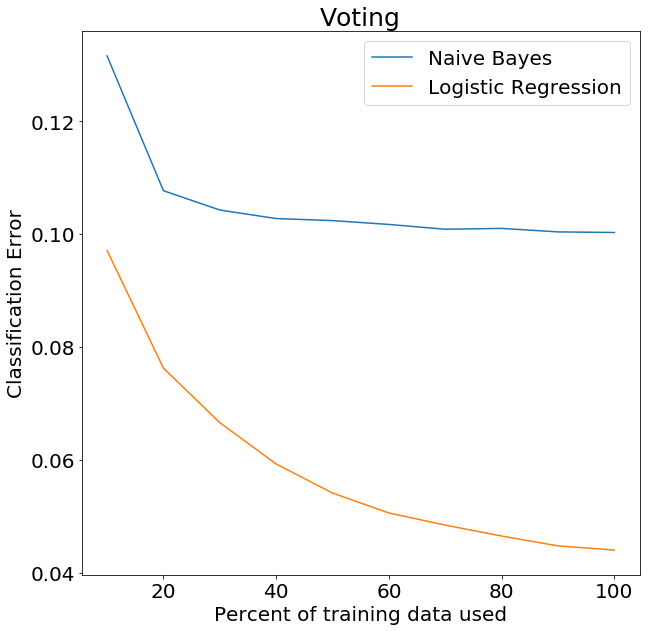

In [8]:
makePlot(nbc_perf_iris, lr_perf_iris, 'Iris')
makePlot(nbc_perf_voting, lr_perf_voting, 'Voting')